# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
OVERWRITE = True
ENTITY_TYPES = ["entities", "fake_entities"]
# QUERY_TYPES = ["closed", "open"]
QUERY_TYPES = ["closed"]
ANSWER_MAP = {
    0: [1621, 642, 7651, 2302, 2369, 7716],
    1: [6279, 4754, 22487, 4374, 9820, 24239],
}

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

In [4]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)
QUERY_IDS = list(yago_qec.keys())
QUERY_ID = QUERY_IDS[0]
SUBNAME = f"{extract_name_from_yago_uri(QUERY_ID)[0]}_{extract_name_from_yago_uri(QUERY_ID)[1]}"
QUERY_IDS[:5], len(QUERY_IDS)

(['http://schema.org/alumniOf',
  'http://schema.org/duration',
  'reverse-http://schema.org/director',
  'http://schema.org/address',
  'http://schema.org/duns'],
 56)

In [5]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [6]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ


In [7]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

Overwriting datasets (if they already exist) at data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/inputs/entities.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/inputs/answers.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/inputs/contexts.json, and data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/inputs/queries.json.


In [8]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [9]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 0, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'fake_entities'], 'QUERY_TYPES': ['closed'], 'ANSWER_MAP': {'0': [1621, 642, 7651, 2302, 2369, 7716], '1': [6279, 4754, 22487, 4374, 9820, 24239]}, 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['yago', 'analysis'], 'LOG_DATASETS': True, 'QUERY_IDS': ['http://schema.org/alumniOf', 'http://schema.org/duration', 'reverse-http://schema.org/director', 'http://schema.org/address', 'http://schema.org/duns', 'http://schema.org/founder', 'http://schema.org/elevation', 'reverse-http://schema.org/editor', 'http://schema.org/lyricist', 'http://schema.org/memberOf', 'http://schema.org/about', 'http://schema.org/gtin', 'http://schema.org/administrates', 'http://sche

### Load Data

In [11]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [12]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2aef3af1c2e0>.


### Analyze Data

In [13]:
val_df_contexts_per_qe.head()

q_id                               query_form  \
0  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
1  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
2  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
3  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
4  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   

                   entity                  answer  \
0    (Margaret Thatcher,)   University of Chicago   
1      (Q. Allan Brocka,)  Washington High School   
2           (S.F. Claus,)    Lycée Louis-le-Grand   
3  (Morris of Aquitaine,)  Nottingham High School   
4      (Sylvester Hicks,)  North Side High School   

                                            contexts  susceptibility_score  \
0  [Israel Zolli is an alum of McGill University ...              0.040123   
1  [Israel Zolli is an alum of McGill University ...              0.059368   
2  [Israel Zolli is an alum of McGill University ...              0.032973   
3  [Israel Zolli is an alum of McGill University ...              0.072812   
4  [Israel Zolli is an alum of McGill University ...              0.072883   

                                  full_query_example  
0  Israel Zolli is an alum of McGill University F...  
1  Israel Zolli is an alum of McGill University F...  
2  Israel Zolli is an alum of McGill University F...  
3  Israel Zolli is an alum of McGill University F...  
4  Israel Zolli is an alum of McGill University F...

In [14]:
val_df_contexts_per_qe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  200 non-null    object 
 1   query_form            200 non-null    object 
 2   entity                200 non-null    object 
 3   answer                200 non-null    object 
 4   contexts              200 non-null    object 
 5   susceptibility_score  200 non-null    float64
 6   full_query_example    200 non-null    object 
dtypes: float64(1), object(6)
memory usage: 12.5+ KB


In [15]:
val_df_contexts_per_qe["entity"].value_counts()

(Margaret Thatcher,)                           2
(Michael Martin,)                              2
(Leonard Beers,)                               2
(Conapa Penzianoti,)                           2
(Carles Magraner,)                             2
                                              ..
(John S. Traill,)                              2
(Campbell,)                                    2
(List of members of the Battle of Alameda,)    2
(Dougal Dixon,)                                2
(Jason Koon,)                                  2
Name: entity, Length: 100, dtype: int64

In [16]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Israel Zolli is an alum of McGill University Faculty of Law.\n',
 "Denny O'Brien is an alum of Uppsala University.\n",
 'Peter McLaughlin is an alum of University of Toronto.\n',
 'Jay Brira is an alum of Yale Law School.\n',
 'Conapa Penzianoti is an alum of Johns Hopkins Bloomberg School of Public Health.\n',
 'Carl Georg With is an alum of University of Minnesota Law School.\n',
 'John Passmore is an alum of Niles West High School.\n',
 'Campbell is an alum of Université de Moncton.\n',
 'Jason Koon is an alum of LaGrange High School.\n',
 'Vitti Meriter is an alum of University of New Mexico.\n']

In [17]:
# import re

# p = r"of\s(.*?)(?=\sis\b)"
# c_ents = [
#     re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
# ]
# ents = val_df_contexts_per_qe["entity"].tolist()
# if (
#     DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
#     and len(set(c_ents).intersection(set(ents))) != 0
# ):
#     raise ValueError(
#         "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
#     )

In [18]:
entities_df = pd.DataFrame(
    {k: v for k, v in yago_qec[QUERY_ID].items() if k in {"entities", "fake_entities"}}
)
real_ents = set(entities_df["entities"])
fake_ents = set(entities_df["fake_entities"])
print("# unique real ents:", len(real_ents))
print("# unique fake ents:", len(fake_ents))
print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
print("Overlapping ents:", real_ents.intersection(fake_ents))
entities_df["entities"].value_counts(), entities_df["fake_entities"].value_counts()

# unique real ents: 999
# unique fake ents: 984
# overlapping ents: 0
Overlapping ents: set()


(Jonathan Powell       2
 Phil Fortunato        1
 Georgios Roilos       1
 Zeno Payne Metcalf    1
 Chris Heaphy          1
                      ..
 Barton Lynch          1
 Lee Young-jin         1
 Paul Girolami         1
 Charles Oxenden       1
 Charles Moseley       1
 Name: entities, Length: 999, dtype: int64,
 Adam and Eve                                         4
 Abraham                                              3
 Margaret Thatcher                                    3
 Adolf Hitler                                         3
 Bobby Bobby                                          2
                                                     ..
 Melchert Baywell                                     1
 Andrey Tharpe                                        1
 Walter Clayford, 1st Viscount Clayford of Angfall    1
 Inau Hill                                            1
 Robert Bruce                                         1
 Name: fake_entities, Length: 984, dtype: int64)

In [19]:
entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
print(entities_df_tidy.head())
entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
entities_df_tidy.head()
entities_df_tidy.info()

       type           entity
0  entities   Phil Fortunato
1  entities   Tuomas Knowles
2  entities     David Rimoin
3  entities  Bruce Dalrymple
4  entities  Zach Charbonnet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    2000 non-null   object
 1   entity  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [20]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    entities_df_tidy,
    left_on="entity",
    right_on="entity",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "contexts",
        "type",
        "susceptibility_score",
    ]
]
val_df_per_qe

q_id  \
0    http://schema.org/alumniOf   
1    http://schema.org/alumniOf   
2    http://schema.org/alumniOf   
3    http://schema.org/alumniOf   
4    http://schema.org/alumniOf   
..                          ...   
199  http://schema.org/alumniOf   
200  http://schema.org/alumniOf   
201  http://schema.org/alumniOf   
202  http://schema.org/alumniOf   
203  http://schema.org/alumniOf   

                                            query_form  \
0              Q: Is {entity} an alum of {answer}?\nA:   
1              Q: Is {entity} an alum of {answer}?\nA:   
2              Q: Is {entity} an alum of {answer}?\nA:   
3              Q: Is {entity} an alum of {answer}?\nA:   
4              Q: Is {entity} an alum of {answer}?\nA:   
..                                                 ...   
199  Q: Does {answer} count {entity} as one of its ...   
200  Q: Does {answer} count {entity} as one of its ...   
201  Q: Does {answer} count {entity} as one of its ...   
202  Q: Does {answer} count {entity} as one of its ...   
203  Q: Does {answer} count {entity} as one of its ...   

                     entity                                answer  \
0      (Margaret Thatcher,)                 University of Chicago   
1      (Margaret Thatcher,)                 University of Chicago   
2      (Margaret Thatcher,)                 University of Chicago   
3        (Q. Allan Brocka,)                Washington High School   
4             (S.F. Claus,)                  Lycée Louis-le-Grand   
..                      ...                                   ...   
199      (Georges de Luna,)                 University of Glasgow   
200  (C. O'Conor Goolrick,)  University of Virginia School of Law   
201            (Permanata,)                   American University   
202              (Dr. Dre,)                       Rollins College   
203           (Jason Koon,)        West Virginia Wesleyan College   

                                              contexts           type  \
0    [Israel Zolli is an alum of McGill University ...  fake_entities   
1    [Israel Zolli is an alum of McGill University ...  fake_entities   
2    [Israel Zolli is an alum of McGill University ...  fake_entities   
3    [Israel Zolli is an alum of McGill University ...       entities   
4    [Israel Zolli is an alum of McGill University ...  fake_entities   
..                                                 ...            ...   
199  [Israel Zolli is an alum of McGill University ...  fake_entities   
200  [Israel Zolli is an alum of McGill University ...       entities   
201  [Israel Zolli is an alum of McGill University ...  fake_entities   
202  [Israel Zolli is an alum of McGill University ...  fake_entities   
203  [Israel Zolli is an alum of McGill University ...       entities   

     susceptibility_score  
0                0.040123  
1                0.040123  
2                0.040123  
3                0.059368  
4                0.032973  
..                    ...  
199              0.057794  
200              0.007800  
201              0.090375  
202              0.019676  
203              0.010504  

[204 rows x 7 columns]

In [21]:
query_forms = val_df_per_qe["query_form"].unique()
query_forms

array(['Q: Is {entity} an alum of {answer}?\nA:',
       'Q: Does {answer} count {entity} as one of its alumni?\nA:'],
      dtype=object)

In [22]:
closed_qfs = yago_qec[QUERY_ID]["query_forms"]["closed"]
open_qfs = yago_qec[QUERY_ID]["query_forms"]["open"]

val_df_per_qe.loc[val_df_per_qe["query_form"].isin(closed_qfs), "query_type"] = "closed"
val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"
val_df_per_qe

q_id  \
0    http://schema.org/alumniOf   
1    http://schema.org/alumniOf   
2    http://schema.org/alumniOf   
3    http://schema.org/alumniOf   
4    http://schema.org/alumniOf   
..                          ...   
199  http://schema.org/alumniOf   
200  http://schema.org/alumniOf   
201  http://schema.org/alumniOf   
202  http://schema.org/alumniOf   
203  http://schema.org/alumniOf   

                                            query_form  \
0              Q: Is {entity} an alum of {answer}?\nA:   
1              Q: Is {entity} an alum of {answer}?\nA:   
2              Q: Is {entity} an alum of {answer}?\nA:   
3              Q: Is {entity} an alum of {answer}?\nA:   
4              Q: Is {entity} an alum of {answer}?\nA:   
..                                                 ...   
199  Q: Does {answer} count {entity} as one of its ...   
200  Q: Does {answer} count {entity} as one of its ...   
201  Q: Does {answer} count {entity} as one of its ...   
202  Q: Does {answer} count {entity} as one of its ...   
203  Q: Does {answer} count {entity} as one of its ...   

                     entity                                answer  \
0      (Margaret Thatcher,)                 University of Chicago   
1      (Margaret Thatcher,)                 University of Chicago   
2      (Margaret Thatcher,)                 University of Chicago   
3        (Q. Allan Brocka,)                Washington High School   
4             (S.F. Claus,)                  Lycée Louis-le-Grand   
..                      ...                                   ...   
199      (Georges de Luna,)                 University of Glasgow   
200  (C. O'Conor Goolrick,)  University of Virginia School of Law   
201            (Permanata,)                   American University   
202              (Dr. Dre,)                       Rollins College   
203           (Jason Koon,)        West Virginia Wesleyan College   

                                              contexts           type  \
0    [Israel Zolli is an alum of McGill University ...  fake_entities   
1    [Israel Zolli is an alum of McGill University ...  fake_entities   
2    [Israel Zolli is an alum of McGill University ...  fake_entities   
3    [Israel Zolli is an alum of McGill University ...       entities   
4    [Israel Zolli is an alum of McGill University ...  fake_entities   
..                                                 ...            ...   
199  [Israel Zolli is an alum of McGill University ...  fake_entities   
200  [Israel Zolli is an alum of McGill University ...       entities   
201  [Israel Zolli is an alum of McGill University ...  fake_entities   
202  [Israel Zolli is an alum of McGill University ...  fake_entities   
203  [Israel Zolli is an alum of McGill University ...       entities   

     susceptibility_score query_type  
0                0.040123     closed  
1                0.040123     closed  
2                0.040123     closed  
3                0.059368     closed  
4                0.032973     closed  
..                    ...        ...  
199              0.057794     closed  
200              0.007800     closed  
201              0.090375     closed  
202              0.019676     closed  
203              0.010504     closed  

[204 rows x 8 columns]

In [23]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

q_id                               query_form  \
77  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
93  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
91  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
58  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
92  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
..                         ...                                      ...   
89  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
96  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
27  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
17  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
84  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   

                       entity                                          answer  \
77  (Elizabeth I of England,)                  United States Military Academy   
93            (Abyad Barana,)                                  Lycée Henri-IV   
91         (Carl Georg With,)                      Norwegian Military College   
58             (Oma Nor Ama,)                Illinois Institute of Technology   
92            (Led Zeppelin,)                                 Yale University   
..                        ...                                             ...   
89        (Edwin A. Andrews,)  University of Music and Performing Arts Vienna   
96   (Jean-Baptiste Lamarck,)                              Cornell University   
27            (Israel Zolli,)                          University of Florence   
17     (Adolfo de Cargagnia,)                         University of Bucharest   
84         (Harley Hamilton,)                       New York College of Music   

                                             contexts           type  \
77  [Israel Zolli is an alum of McGill University ...  fake_entities   
93  [Israel Zolli is an alum of McGill University ...  fake_entities   
91  [Israel Zolli is an alum of McGill University ...       entities   
58  [Israel Zolli is an alum of McGill University ...  fake_entities   
92  [Israel Zolli is an alum of McGill University ...  fake_entities   
..                                                ...            ...   
89  [Israel Zolli is an alum of McGill University ...  fake_entities   
96  [Israel Zolli is an alum of McGill University ...  fake_entities   
27  [Israel Zolli is an alum of McGill University ...       entities   
17  [Israel Zolli is an alum of McGill University ...  fake_entities   
84  [Israel Zolli is an alum of McGill University ...       entities   

    susceptibility_score query_type  
77              0.010840     closed  
93              0.019516     closed  
91              0.020156     closed  
58              0.021968     closed  
92              0.027675     closed  
..                   ...        ...  
89              0.109008     closed  
96              0.113199     closed  
27              0.122684     closed  
17              0.126643     closed  
84              0.133755     closed  

[102 rows x 8 columns]

In [24]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]][
    ["entity", "type", "susceptibility_score"]
].sort_values(by="susceptibility_score")

entity           type  susceptibility_score
77  (Elizabeth I of England,)  fake_entities              0.010840
93            (Abyad Barana,)  fake_entities              0.019516
91         (Carl Georg With,)       entities              0.020156
58             (Oma Nor Ama,)  fake_entities              0.021968
92            (Led Zeppelin,)  fake_entities              0.027675
..                        ...            ...                   ...
89        (Edwin A. Andrews,)  fake_entities              0.109008
96   (Jean-Baptiste Lamarck,)  fake_entities              0.113199
27            (Israel Zolli,)       entities              0.122684
17     (Adolfo de Cargagnia,)  fake_entities              0.126643
84         (Harley Hamilton,)       entities              0.133755

[102 rows x 3 columns]

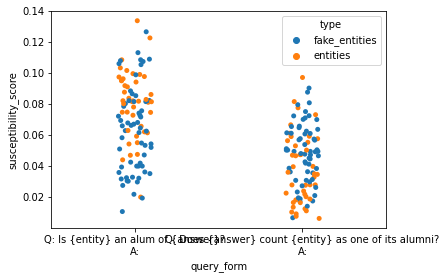

In [29]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = f"plot_susscore_vs_queryform_real_fake_{SUBNAME}"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

<AxesSubplot:xlabel='entity_mentions_in_contexts', ylabel='susceptibility_score'>

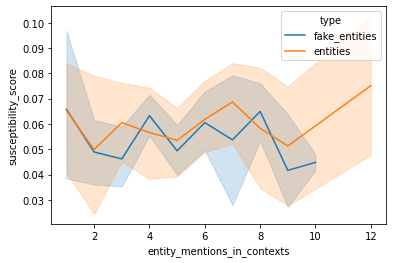

In [26]:
val_df_per_qe["entity_mentions_in_contexts"] = val_df_per_qe.apply(
    lambda row: sum([row["entity"][0] in context for context in row["contexts"]]),
    axis=1,
)
sns.lineplot(
    data=val_df_per_qe,
    x="entity_mentions_in_contexts",
    y="susceptibility_score",
    hue="type",
)
# val_df_per_qe

In [30]:
def construct_df_given_query_id(query_id: List[str], verbose=True):
    # Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
    (
        data_dir,
        input_dir,
        entities_path,
        contexts_path,
        queries_path,
        answers_path,
        val_data_path,
        model_dir,
        results_dir,
        val_results_path,
        data_id,
        model_id,
        DATASET_KWARGS_IDENTIFIABLE,
    ) = construct_paths_and_dataset_kwargs(
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        OVERWRITE=OVERWRITE,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
        ANSWER_MAP=ANSWER_MAP,
    )
    # Analysis dir
    analysis_dir = os.path.join(data_dir, "analysis")
    if verbose:
        print(f"Analysis dir: {analysis_dir}")
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)

    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    from ast import literal_eval

    try:
        val_df_contexts_per_qe = pd.read_csv(
            val_results_path,
            index_col=0,
            converters={"contexts": literal_eval, "entity": literal_eval},
        )
    except FileNotFoundError as e:
        print(f"Unable to find file at {val_results_path}, full error: {e}")
        return None
    if verbose:
        print("val_df_contexts_per_qe info:")
        print(val_df_contexts_per_qe.info())
        print(val_df_contexts_per_qe["entity"].value_counts())
        print(val_df_contexts_per_qe.iloc[0]["contexts"][:10])
        print("Entities info:")
    entities_df = pd.DataFrame(
        {
            k: v
            for k, v in yago_qec[query_id].items()
            if k in {"entities", "fake_entities"}
        }
    )
    real_ents = set(entities_df["entities"])
    fake_ents = set(entities_df["fake_entities"])

    entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
    entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
    if verbose:
        print("# unique real ents:", len(real_ents))
        print("# unique fake ents:", len(fake_ents))
        print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
        print("Overlapping ents:", real_ents.intersection(fake_ents))
        print(
            entities_df["entities"].value_counts(),
            entities_df["fake_entities"].value_counts(),
        )
        print(entities_df_tidy.head())
        print(entities_df_tidy.info())

    val_df_per_qe = val_df_contexts_per_qe.merge(
        entities_df_tidy,
        left_on="entity",
        right_on="entity",
        how="left",
    )[
        [
            "q_id",
            "query_form",
            "entity",
            "answer",
            "contexts",
            "type",
            "susceptibility_score",
        ]
    ]
    query_forms = val_df_per_qe["query_form"].unique()
    closed_qfs = yago_qec[query_id]["query_forms"]["closed"]
    open_qfs = yago_qec[query_id]["query_forms"]["open"]

    val_df_per_qe.loc[
        val_df_per_qe["query_form"].isin(closed_qfs), "query_type"
    ] = "closed"
    val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"

    if verbose:
        print("val_df_per_qe info:")
        print(val_df_per_qe)

        print(f"query forms: {query_forms}")
        print(
            "Sorted sus scores:",
            val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
                by="susceptibility_score"
            ),
        )

    return val_df_per_qe

In [31]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(query_id, verbose=False)
    for query_id in QUERY_IDS
}

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0
Model dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0
Model dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_address/schema_address-mc500-me100-ET_entities_fake_entities-QT_closed-AM_a5bceff6/0
Model dir: data/Yag

In [32]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/award', 'http://schema.org/address', 'http://schema.org/motto', 'http://schema.org/gtin', 'http://schema.org/founder'}


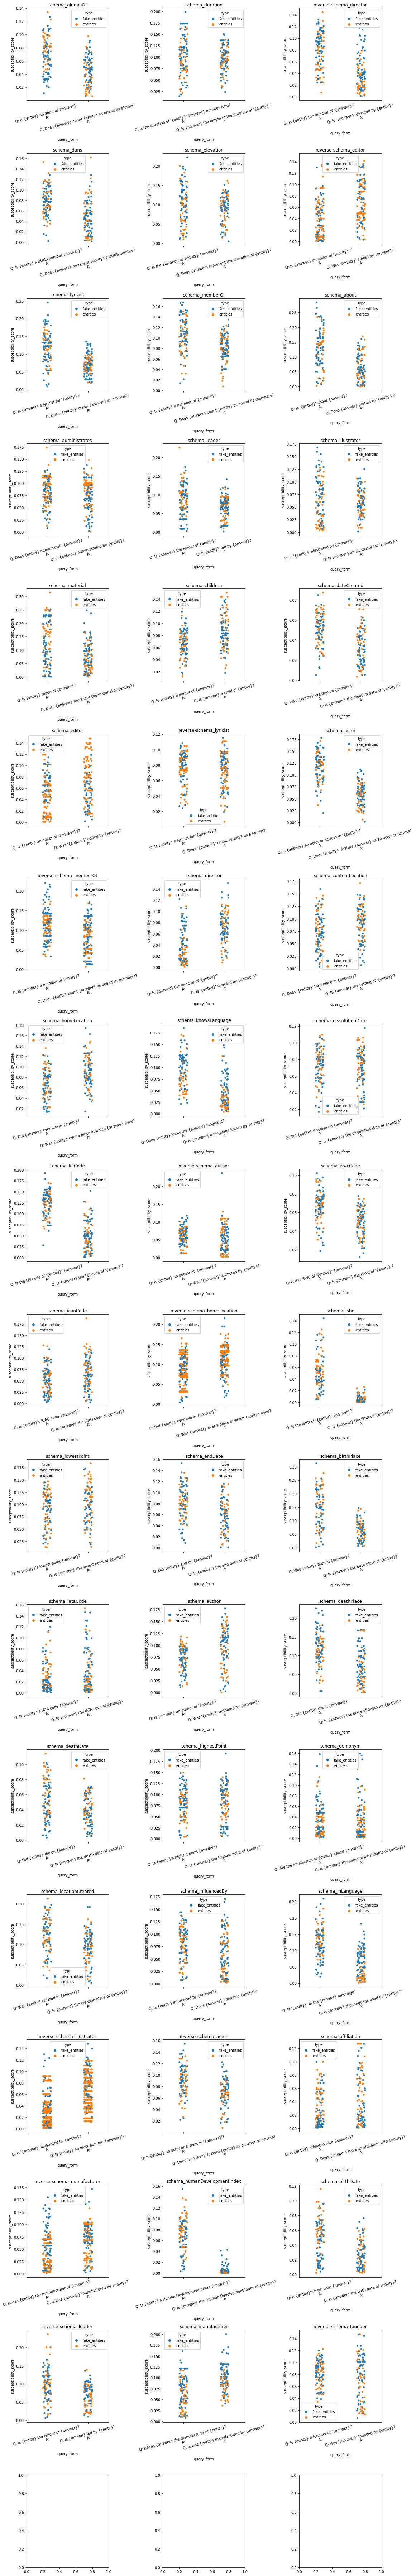

In [33]:
import math

num_plots = len(qid_to_val_df_per_qe)
num_cols = 3
num_rows = math.ceil(num_plots // 3) + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(16, 100))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    row = math.ceil(count // num_cols)
    col = count % num_cols
    ax = axes[row][col]
    sns.stripplot(
        data=df,
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # hue="is_real",
        # dodge=True
        # jitter=0.1,
        # legend="full",
    )
    subname = (
        f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
    )
    ax.set_title(subname)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

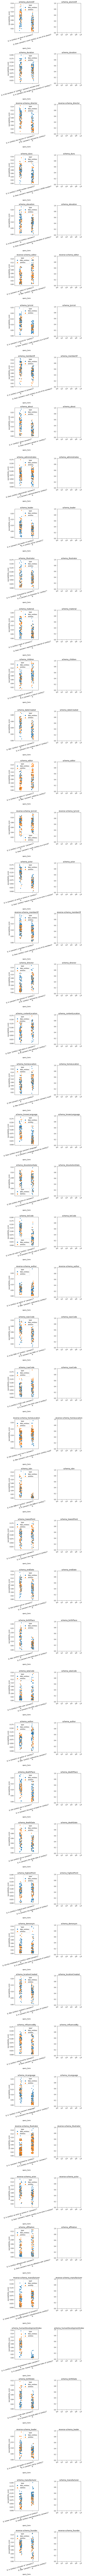

In [34]:
import math

num_rows = len(qid_to_val_df_per_qe)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 250))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.stripplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            # hue="is_real",
            # dodge=True
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [35]:
from scipy.stats import ttest_ind


def ttest(df):
    sus_scores_real = df[df["type"] == "entities"]["susceptibility_score"]
    sus_scores_fake = df[df["type"] == "fake_entities"]["susceptibility_score"]
    ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    ttest_res = ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    t_stat, p_value = ttest_res.statistic, ttest_res.pvalue
    # print(t_stat, p_value)
    cohen_d = t_stat * np.sqrt(
        (len(sus_scores_real) + len(sus_scores_fake))
        / (len(sus_scores_real) * len(sus_scores_fake))
    )
    cohen_d2 = (np.mean(sus_scores_real) - np.mean(sus_scores_fake)) / np.sqrt(
        (
            np.var(sus_scores_real, ddof=1) * (len(sus_scores_real) - 1)
            + np.var(sus_scores_fake, ddof=1) * (len(sus_scores_fake) - 1)
        )
        / (len(sus_scores_real) + len(sus_scores_fake) - 2)
    )
    assert np.isclose(cohen_d, cohen_d2)
    # effect_size,
    return {
        "effect_size": cohen_d,
        "p_value": p_value,
        "n": len(sus_scores_fake) + len(sus_scores_real),
    }


# ttest_scores = [{"query": k, **ttest(v)} for k, v in qid_to_val_df_per_qe.items()]
ttest_scores = [
    {"query": k, **ttest(v[v["query_type"] == "closed"])}
    for k, v in qid_to_val_df_per_qe.items()
]
# ttest_scores = [{"query": k, **ttest(v[v["query_type"] == "open"])} for k, v in qid_to_val_df_per_qe.items()]

pd.DataFrame(ttest_scores).sort_values(by="p_value").reset_index(drop=True)

query  effect_size       p_value    n
0     reverse-http://schema.org/illustrator    -0.523256  1.965898e-07  834
1            http://schema.org/manufacturer    -0.696926  5.171764e-07  218
2           http://schema.org/knowsLanguage    -0.574211  3.438014e-05  208
3    reverse-http://schema.org/manufacturer    -0.434803  3.449477e-05  348
4             http://schema.org/illustrator    -0.547313  4.179961e-05  216
5        reverse-http://schema.org/director    -0.528094  6.578897e-05  220
6              http://schema.org/deathPlace    -0.429879  1.468513e-03  202
7                http://schema.org/duration    -0.331409  8.893111e-03  220
8                http://schema.org/director    -0.328112  9.762525e-03  214
9        reverse-http://schema.org/memberOf    -0.234369  1.526648e-02  344
10              http://schema.org/elevation    -0.306261  1.540807e-02  210
11        reverse-http://schema.org/founder    -0.301298  1.647229e-02  210
12             http://schema.org/inLanguage    -0.285365  1.868449e-02  230
13               http://schema.org/memberOf    -0.279154  2.293182e-02  216
14          reverse-http://schema.org/actor    -0.284406  2.349915e-02  202
15                http://schema.org/demonym    -0.240116  2.444905e-02  274
16         reverse-http://schema.org/editor    -0.238235  2.951391e-02  282
17         reverse-http://schema.org/author    -0.231662  4.062146e-02  230
18         reverse-http://schema.org/leader    -0.171727  1.060429e-01  214
19           http://schema.org/influencedBy    -0.156709  1.140494e-01  238
20                  http://schema.org/actor    -0.148874  1.474719e-01  206
21           http://schema.org/highestPoint    -0.132839  1.656134e-01  226
22       reverse-http://schema.org/lyricist    -0.105335  1.961596e-01  270
23                  http://schema.org/about    -0.048680  3.649995e-01  210
24                http://schema.org/leiCode    -0.032024  4.093708e-01  216
25                 http://schema.org/author    -0.001073  4.969545e-01  212
26               http://schema.org/lyricist     0.000942  5.028153e-01  234
27               http://schema.org/children     0.012510  5.351106e-01  204
28                http://schema.org/endDate     0.035798  5.988719e-01  202
29                   http://schema.org/duns     0.054146  6.504781e-01  210
30        http://schema.org/locationCreated     0.062819  6.703654e-01  204
31  http://schema.org/humanDevelopmentIndex     0.072845  6.982580e-01  204
32               http://schema.org/iataCode     0.084252  7.324467e-01  238
33               http://schema.org/material     0.092793  7.582232e-01  240
34               http://schema.org/iswcCode     0.108478  7.782124e-01  208
35                 http://schema.org/editor     0.111830  8.098535e-01  274
36               http://schema.org/alumniOf     0.130214  8.194433e-01  204
37                   http://schema.org/isbn     0.130656  8.212308e-01  200
38                 http://schema.org/leader     0.184199  9.241542e-01  256
39             http://schema.org/birthPlace     0.239970  9.522418e-01  200
40           http://schema.org/homeLocation     0.248319  9.593138e-01  206
41        http://schema.org/contentLocation     0.260256  9.665420e-01  206
42            http://schema.org/lowestPoint     0.276953  9.774760e-01  212
43            http://schema.org/dateCreated     0.338794  9.904958e-01  200
44        http://schema.org/dissolutionDate     0.347209  9.928977e-01  212
45               http://schema.org/icaoCode     0.352275  9.935642e-01  212
46            http://schema.org/affiliation     0.427414  9.991742e-01  224
47              http://schema.org/birthDate     0.470714  9.994873e-01  208
48   reverse-http://schema.org/homeLocation     0.341873  9.995962e-01  596
49              http://schema.org/deathDate     0.627079  9.999915e-01  204
50          http://schema.org/administrates     0.568969  9.999988e-01  290

### Examining model outputs

In [ ]:
# TODO: (1) try answer_map thing, and also (2) randomly sample so that each entity shows up in contexts evenly

In [ ]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [ ]:
def print_top_k_next_token_probs(
    model, tokenizer, query, entity, context, answer=None, k=50
):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(
                    query=query, entity=entity, context=context, answer=answer
                ),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [ ]:
val_df_contexts_per_qe.info(), val_df_per_qe.info()

In [ ]:
val_df_per_qe.drop(
    columns=["contexts", "type", "q_id", "entity_mentions_in_contexts"]
).value_counts()

In [ ]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

In [ ]:
entity_to_context_mentions = {
    entity: sum([entity[0] in context for context in val_df_per_qe.iloc[0]["contexts"]])
    for entity in val_df_per_qe["entity"].unique()
}
entity_to_context_mentions = dict(
    sorted(entity_to_context_mentions.items(), key=lambda x: x[1])
)
print("Number of contexts each entity is mentioned in:")
entity_to_context_mentions

In [ ]:
pp = pprint.PrettyPrinter()
query_id = "reverse-http://schema.org/manufacturer"
val_df_per_qe = qid_to_val_df_per_qe[query_id]
# print(val_df_per_qe)
row = (
    val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
answer = row["answer"]
print("entity:", entity)
contexts = row["contexts"]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context="", answer=answer))
print(
    "CMI:",
    estimate_cmi(query, entity, contexts, model, tokenizer, answer_entity=answer),
)

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(
    model, tokenizer, query, entity, context="", k=50, answer=answer
)
print("\n\n")
print("Top-k next token probs WITH context mentioning entity")
for context in contexts:
    if entity[0] in context:
        print(
            f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
        )
        print_top_k_next_token_probs(
            model, tokenizer, query, entity, context, k=50, answer=answer
        )
        print("\n\n")
print("\n\n")
print("Top-k next token probs WITH context NOT mentioning entity")
for context in contexts[:5]:
    print(
        f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
    )
    print_top_k_next_token_probs(
        model, tokenizer, query, entity, context, k=50, answer=answer
    )
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context="", answer=answer),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

In [ ]:
tokenizer([" Nope"])

### Correlation with Pile frequency

In [ ]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [ ]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [ ]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

In [ ]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

In [ ]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [ ]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

In [ ]:
entities_to_freqs

In [ ]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [ ]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

In [ ]:
unigram_frequencies

In [ ]:
tokenizer.convert_ids_to_tokens([38581])

In [ ]:
wandb.finish()